In this tutorial, we are going to show how to set up a "master" script to set up BICePs samplings. You are welcome to take this as a template for you and make necessary modification to get it work for you. All input files used in this tutorial are prepared from [this tutorial](https://github.com/vvoelz/biceps/blob/master/BICePs_2.0/tutorials/Preparation/Preparation.ipynb).

A template based on this tutorial is available [here](https://github.com/vvoelz/biceps/tree/master/BICePs_2.0/templates). You are welcome to take it as a template and make modification to prepare your own scripts. The dataset used in this tutorial can be found [here](https://github.com/vvoelz/biceps/tree/master/BICePs_2.0/tutorials/data_set).

Yunhui Ge  --02/2019

First, we need to import source code for BICePs classes. More information of these classes can be found [here](https://github.com/vvoelz/biceps/blob/master/BICePs_2.0/markdown/workflow.md).

In [17]:
# import source code
import sys, os, glob
from numpy import *
sys.path.append('../../')

import biceps
from biceps import *
# dir(biceps)

Now we need to specify input files and output files folder.

In [18]:
############ Initialization #############
# Specify necessary argument values

# REQUIRED: specify number of states
states=100

# REQUIRED: specify directory of input data (BICePs readable format)
dataFiles = 'noe_J'   

# REQUIRED: sort data and figure out what experimental restraints are included for each state
data = sort_data(dataFiles)

# REQUIRED: energy file name of each state (computational prior distribution)

energies_filename = 'energy.dat'
energies = loadtxt(energies_filename)
energies -= energies.min()  # set ground state to zero, just in case

# REQUIRED: specify outcome directory of BICePs sampling
outdir = 'results_ref_normal'
# Make a new directory if we have to
if not os.path.exists(outdir):
    os.mkdir(outdir)


Next, we need to specify number of steps for BICePs sampling. We recommend to run at least 1M steps for converged Monte Carlo samplings. In BICePs, we also prepare functions of checking convergence of Monte Carlo. More information can be found [here].

In [19]:
# REQUIRED: number of MCMC steps for each lambda
nsteps = 1000000

We need to specify what lambda values we want to use in BICePs samplings. Briefly, lambda values are similar to the parameters used in free energy perturbation (FEP) and has effect on the BICePs score. The lambda values represent how much prior information from computational modeling is included in BICePs sampling (1.0 means all, 0.0 means none). As we explained in [this work](https://pubs.acs.org/doi/10.1021/acs.jpcb.7b11871), one can consider BICePs score as the relative free energy change between different models. More lambda values will increase the samplings for [multistate Bennett acceptance ratio (MBAR)](http://www.alchemistry.org/wiki/Multistate_Bennett_Acceptance_Ratio) predictions in free energy change and populations. However more lambda values also will slow down the whole process of BICePs (as more samplings need to run), so balancing the accuracy and efficiency is important. To successfully finish a BICePs sampling, lambda values of 0.0 and 1.0 are necessary. Based on our experience, the lambda values of 0.0,0.5,1.0 are good enough for BICePs sampling.

In [20]:
# REQUIRED: specify how many lambdas to sample (more lambdas will provide higher accuracy but slower the whole process, lambda=0.0 and 1.0 are necessary)
lambda_values = [0.0,0.5,1.0]

Print what experimental observables are included in BICePs sampling. This is optional and provides a chance for double check before running BICePs sampling.

In this tutorial, we used both J couplings and NOE (pairwise distances) in BICePs sampling. 

In [21]:
# OPTIONAL but RECOMMENDED: print experimental restraints included (a chance for double check)
res = list_res(data)
print res
  

['J', 'noe']


Another key parameter for BICePs set-up is the type of reference potential for each experimental observables. More information of reference potential can be found [here](https://github.com/vvoelz/biceps/blob/master/BICePs_2.0/markdown/Theory.ipynb).

Three reference potentials are supported in BICePs: uniform ('uniform'), exponential ('exp'), Gaussian ('gau').  

As we found in previous research, exponential reference potential is useful in most cases. Some higher level task may require more in reference potential selection (e.g [force field parametrization](https://pubs.acs.org/doi/10.1021/acs.jpcb.7b11871)).

(Noet: It will be helpful to print out what is the order of experimental observables included in BICePs sampling as shown above.)

In [22]:
# REQUIRED: specify reference potential to use for each experimental observable
# will be in the same order as the printed observables from (print res)
ref=['uniform','exp']


If you want, you can specify nuisance parameters (uncertainty in experiments) range but it's not required. Our default parameters range is broad enough.
"gamma" is a scaling factor converting distances to NOE intensity in experiments. It is only used when NOE restraint is ued in BICePs sampling.

In [23]:
# OPTIONAL: specify nuisance parameters for each experimnetal observable
# will be in the same order as the printed observables from (print res)
# only specify if you want to narrow down the default range  
uncern=[[0.05,20.0,1.02],[0.05,5.0,1.02]]
gamma = [0.2,5.0,1.01]  

Now we need to set up BICePs samplings and feed arguments using variables we defined above. In most cases, you don't need to modify this part as long as you defined all these parameters shown above. 

In [26]:
init_res()

TypeError: init_res() takes at least 4 arguments (0 given)

In [27]:
######################
# Main:
######################

for j in lambda_values:
    print 'lambda', j
    verbose = False #False
    lam = j
    # We will instantiate a number of Restraint() objects to construct the ensemble
    # experimental data and pre-computed model data are compiled for each state
    ensemble = []
    for i in range(energies.shape[0]):   # number of states
        if verbose:
            print '\n#### STRUCTURE %d ####'%i
        ensemble.append([])
        for k in range(len(data[0])):   # number of experimental observables
            File = data[i][k]
            if verbose:
                print File
            R = init_res('top/%d.fixed.pdb'%i,lam,energies[i],ref[k],File,uncern[k],gamma)
            ensemble[-1].append(R)
        #print ensemble
        
        
    ##########################################
    # Next, let's do posterior MCMC sampling
    ########## Posterior Sampling ############

    sampler = PosteriorSampler(ensemble)
    sampler.compile_nuisance_parameters()

    sampler.sample(nsteps)  # number of steps

    print 'Processing trajectory...',

    sampler.traj.process()  # compute averages, etc.
    print '...Done.'
    print 'Writing results...',
    sampler.traj.write_results(os.path.join(outdir,'traj_lambda%2.2f.npz'%lam))
    print '...Done.'
    sampler.traj.read_results(os.path.join(outdir,'traj_lambda%2.2f.npz'%lam))     
    print 'Pickling the sampler object ...',
    outfilename = 'sampler_lambda%2.2f.pkl'%lam
    print outfilename,
    fout = open(os.path.join(outdir, outfilename), 'wb')
    # Pickle dictionary using protocol 0.
    cPickle.dump(sampler, fout)
    fout.close()
    print '...Done.'



lambda 0.0


UnboundLocalError: local variable 'R' referenced before assignment

Now you can check your pre-defined output folder and see if the output files from BICePs sampling are there. In this case, we defined `outdir` as 'results_ref_normal'.

In [10]:
ls results_ref_normal/*

results_ref_normal/sampler_lambda0.00.pkl
results_ref_normal/sampler_lambda0.50.pkl
results_ref_normal/sampler_lambda1.00.pkl
results_ref_normal/traj_lambda0.00.npz
results_ref_normal/traj_lambda0.50.npz
results_ref_normal/traj_lambda1.00.npz


Then, we need to run functions in `Analysis` to get predicted populations of each conformational states and BICePs score. A figure of posterior distribution of populations and nuisance parameters will be plotted as well. 

Loading results_ref_normal/traj_lambda0.00.npz ...
Loading results_ref_normal/traj_lambda0.50.npz ...
Loading results_ref_normal/traj_lambda1.00.npz ...
Loading results_ref_normal/sampler_lambda0.00.pkl ...
Loading results_ref_normal/sampler_lambda0.50.pkl ...
Loading results_ref_normal/sampler_lambda1.00.pkl ...
lam = [0.0, 0.5, 1.0]
nstates 100
Writing BS.dat...
...Done.
Writing populations.dat...
...Done.


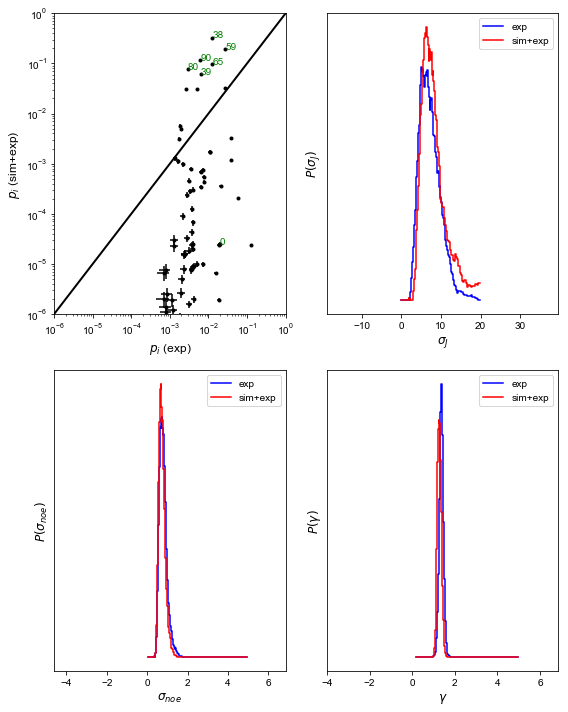

In [13]:
#########################################
# Let's do analysis using MBAR algorithm and plot figures
############ MBAR and Figures ###########
# Specify necessary argument values

%matplotlib inline

nstates = 100
A = Analysis(nstates, dataFiles, outdir)
A.plot()


The output files include: population information ("populations.dat"), figure of sampled parameters distribution ("BICePs.pdf"), BICePs score information ("BS.dat").

First, let's take a look at the populations file.

In [14]:
fin = open('populations.dat','r')
text = fin.read()
fin.close()
print text

1.940951750211206139e-02 1.965295952585544015e-03 2.518654530092589994e-05 1.312192450287664146e-03 1.346988432769095814e-04 1.731430769268453722e-06
3.973859690611369899e-03 5.176070440751079360e-04 8.533265313914739636e-06 5.910857636645087823e-04 7.719505082542716843e-05 1.273572543192784700e-06
7.066926003822748825e-03 6.480830834055151257e-03 7.522431621209690888e-04 5.901280465293672582e-04 5.401060184726528190e-04 6.309701334641999357e-05
7.789946228009547724e-04 2.135928486708404961e-04 7.412528528316641996e-06 2.462451425520415394e-04 6.754409265688017712e-05 2.344652387111030718e-06
0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00 nan
1.299690406472597815e-03 3.095841929479092869e-07 9.334755191048316192e-12 3.601857994946521305e-04 8.588729229939138591e-08 nan
7.506524582218565556e-03 5.654387450233056001e-03 5.390879675479798294e-04 6.399815494293711101e-04 4.817773260234562978e-04 4.619991286908470

There are 100 rows corresponding to 100 clustered states. 6 columns corresponding to populations of each state (row) for 3 lambda values (first 3 columns) and population change (last 3 columns). 

Then let's take a look at the output figure ("BICePs.pdf").

<img src="BICePs.png" height="500" width="500">

The top left panel shows the population of each states in the presence (y-axis) and absense (x-axis) of computational modeling prior information. You can find some states (e.g state 38, 59) get awarded after including computational prior information. If you check [this work](https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.23738) you will see how misleading the results will be if we only use experimental restraints without computational prior information. 
The other three panels show the distribution of nuisance parameters in the presence or absence of computational modeling information. It may not be clear in this example due to the limit of finite sampling, but based on our experience, including prior information from our simulations will lower the nuisance parameters than only using experimental restraints.